## Basic Bayesian Optimization
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on a
 simple test problem.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    # return multiple noisy measurements
    return {"f": np.sin(input_dict["x"]) + 0.5*np.random.randn(5),
            "dummy": np.random.randn(5)}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acqusition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = UpperConfidenceBoundGenerator(vocs=vocs, model_constructor=model_constructor)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate 3 initial points
X.random_evaluate(2)

# inspect the gathered data
X.data

,x,f,dummy,xopt_runtime,xopt_error
0,3.369005,0.450178,-2.409888,0.000057,False
0,3.369005,-0.614239,0.206744,0.000057,False
0,3.369005,0.853933,1.831908,0.000057,False
0,3.369005,-0.605871,-0.11346,0.000057,False
0,3.369005,0.567931,-2.779417,0.000057,False
1,3.752501,-0.593961,-1.637384,0.000009,False
1,3.752501,-0.675928,0.862139,0.000009,False
1,3.752501,-0.921747,-0.38127,0.000009,False
1,3.752501,-0.978916,-0.632713,0.000009,False
1,3.752501,-0.947042,1.200956,0.000009,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/generators/bayesian/models/standard.py:95: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True
/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/generators/bayesian/models/standard.py:95: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True
/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/generators/bayesian/models/standard.py:95: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True
/usr/share/miniconda3/envs/xopt-dev/lib/python3.9/site-packages/xopt/generators/bayesian/models/standard.py:95: Future

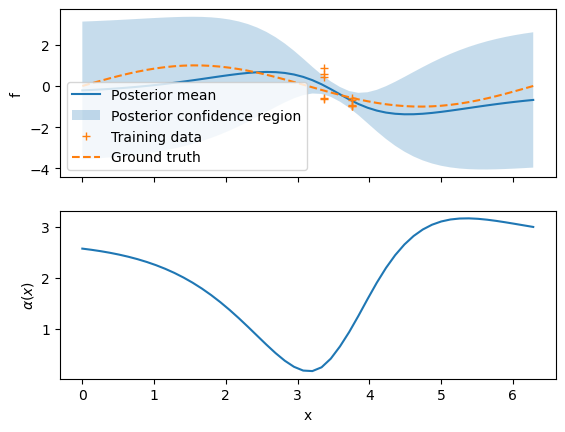

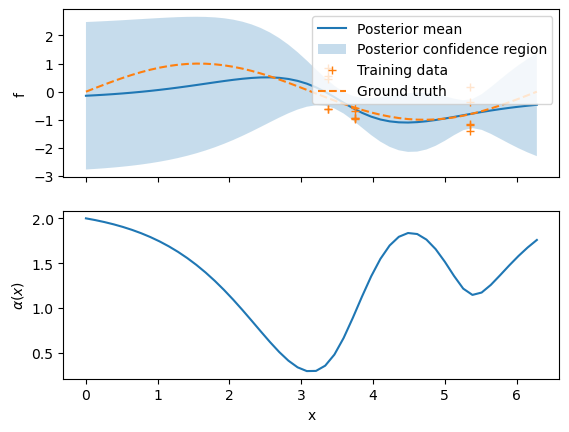

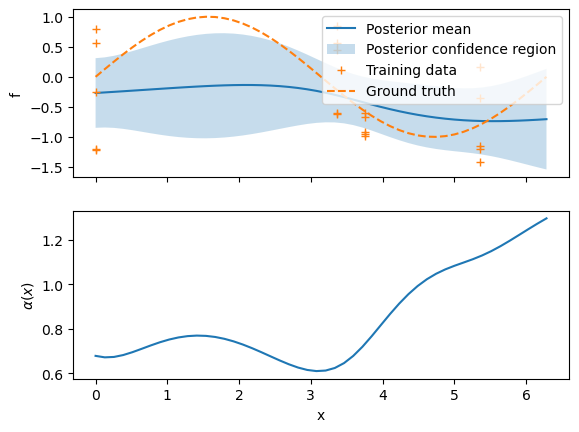

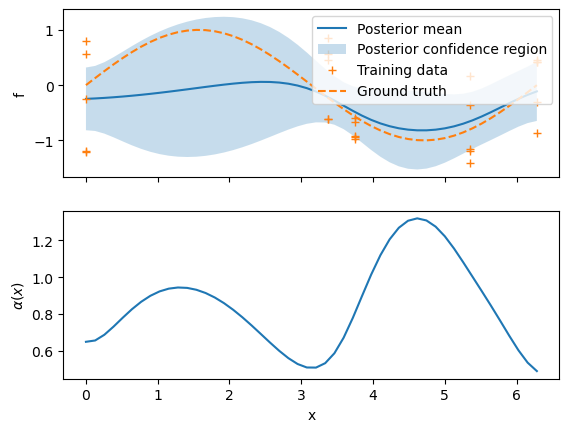

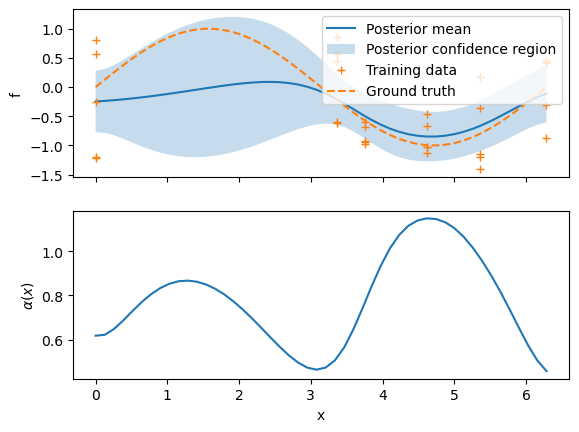

In [5]:
import torch
import matplotlib.pyplot as plt

n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1, 1, 1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(2, 1, sharex="all")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u, alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"], X.data["f"], "C1+", label="Training data")

    # plot true function
    true_f = np.sin(test_x)
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend()

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # do the optimization step
    X.step()


In [6]:
# access the collected data
X.data

,x,f,dummy,xopt_runtime,xopt_error
0,3.369005,0.450178,-2.409888,0.000057,False
0,3.369005,-0.614239,0.206744,0.000057,False
0,3.369005,0.853933,1.831908,0.000057,False
0,3.369005,-0.605871,-0.11346,0.000057,False
0,3.369005,0.567931,-2.779417,0.000057,False
1,3.752501,-0.593961,-1.637384,0.000009,False
1,3.752501,-0.675928,0.862139,0.000009,False
1,3.752501,-0.921747,-0.38127,0.000009,False
1,3.752501,-0.978916,-0.632713,0.000009,False
1,3.752501,-0.947042,1.200956,0.000009,False


## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [7]:
X.generator.get_optimum()

,x
0,4.675523


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [8]:
X.generator.dict()

{'model': ModelListGP(
   (models): ModuleList(
     (0): SingleTaskGP(
       (likelihood): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
       (mean_module): ConstantMean()
       (covar_module): ScaleKernel(
         (base_kernel): MaternKernel(
           (lengthscale_prior): GammaPrior()
           (raw_lengthscale_constraint): Positive()
         )
         (outputscale_prior): GammaPrior()
         (raw_outputscale_constraint): Positive()
       )
       (outcome_transform): Standardize()
       (input_transform): Normalize()
     )
   )
   (likelihood): LikelihoodList(
     (likelihoods): ModuleList(
       (0): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
     )
   )
 ),
 'turbo_controller': None,
 'use_cuda':